<a href="https://colab.research.google.com/github/dmousav1/JHU-Neural-Networks/blob/main/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Programming

The following notebook contains skeleton-code for answering problems 2 and 3 of homework assignment 2. Please read through each cell carefully to understand what is expected to be implemented. For your final submission, please try to clean up any intermediate outputs used for debugging.

### Imports

You should be able to complete the entire assignment using only the following imports. Please consult the course staff if you are unsure about whether additional packages may be used.

In [ ]:
## Import Packages
import random
import numpy as np
import matplotlib.pyplot as plt

## Question 2


Below we provide an AutoGrad class named `Value`. The basic idea is to store the existing computational map during the creation of each `Value`, and calculate the gradient using backpropagation when one of the `Value` calls `backward()` method.

The `backward()` function will arange the computational graph and backpropagate the gradients. All you need to do is to implement all the operations with its corresponding `_backward` function. We have provided the `__add__` function (sum of two nodes) as an example to help get you started.

This notebook is designed in a Object Oriented way, if you are not farmiliar with the Object Oriented Programming in Python, you can refer to:

(1) https://realpython.com/python3-object-oriented-programming/

(2) https://docs.python.org/3/tutorial/classes.html


In [108]:
class Value:

    """
    Basic unit of storing a single scalar value and its gradient
    """

    def __init__(self, data, _children=()):
        """

        """
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._backward = lambda: None

    def __add__(self, other):
        """
        Example implementation of a single class operation (addition)

        Args:
            other (Any): Node to add with the class

        Returns:
            out (callable): Function to referesh the gradient
        """
        #Firstly, convert some default value type in python to Value
        #Then do operations with two or more Value object
        other = other if isinstance(other, Value) else Value(other)

        #Secondly, create a new Value object which is the result of the operation
        out = Value(self.data + other.data, (self, other))

        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens,
        #Then assign this _backward function to the output object.
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        Multiplication operation (e.g. Value(3) * Value(2) = Value(6))
        """
        #TODO implement multiplication operation

        # Make other of the Value class if it isn't already
        other = other if isinstance(other, Value) else Value(other)

        # Create a new Value object with the product in it
        out = Value(self.data * other.data, (self, other))

        # Thirdly, create a backward function for the output object
        # to refresh the gradient of its children. Then assign this _backward
        # function to the output object.

        def _backward():
          self.grad += other.data * out.grad # Partial Derivate = b
          other.grad += self.data * out.grad # Partial Derivate = a

        out._backward = _backward

        return out

    def __pow__(self, other):
        """
        Power operation (e.g Value(3) ** 2 = Value(9))
        """
        #TODO implement power operation, we don't need to convert the exponent to Value
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,))
        # Does the power operation but keeps other as a float/int and not
        # a Value object

        def _backward():
          self.grad += (other)*(self.data ** (other-1)) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        """
        ReLU activation function applied to the current Value
        """
        #TODO implement the relu activation function for the value itself.
        out = Value(max(0, self.data), (self,)) # If self.data <= 0, it becomes 0

        def _backward():
          self.grad += (1.0 if self.data > 0 else 0.0) * out.grad # ReLU derivative

        out._backward = _backward

        return out


    def exp(self):
        """
        Exponentiate the current Value (e.g. e ^ Value(0) = Value(1))
        """
        out = Value(np.exp(self.data), (self,))

        def _backward():
          self.grad += out.data * out.grad
          # We use out.data and not np.exp(self.data) since we already computed it

        out._backward = _backward

        return out

    def log(self):
        """
        Take the natural logarithm (base e) of the current Value
        """
        #TODO implement the logarithm function for and treat the value as exponent.
        #The bottom number should be e, you can use numpy to calculate the value of the logarithm.

        # Add a small epsilon to avoid log(0) and ensure positive input
        epsilon = 1e-10
        out = Value(np.log(self.data + epsilon), (self,)) # Apply abs() to self.data.data

        def _backward():
            self.grad += (1.0/(self.data + epsilon) if self.data >=0 else -1.0/(self.data - epsilon)) * out.grad # Derivative of log(abs(x))
        out._backward = _backward

        return out

    def backward(self):
        """
        Run backpropagation from the current Value
        """
        #This function is called when you start backpropagation from this Value

        #The gradient of this value is initialized to 1 for you.
        self.grad = 1

        #You need to find a right topological order all of the children in the graph.
        #As for topology sort, you can refer to http://www.cs.cornell.edu/courses/cs312/2004fa/lectures/lecture15.htm
        topo = []
        visited = set()
        #TODO find the right list of Value to be traversed

        def build_topo(val):
          if val not in visited:
            visited.add(val)
            for child in val._prev:
              build_topo(child)
            topo.append(val)

        build_topo(self)
        '''
        Hint: you can recursively visit all non-visited node from the node calling backward.
        add one node to the head of the list after all of its children node are visited
        '''

        #go one variable at a time and apply the chain rule to get its gradient

        for v in reversed(topo):
            v._backward()

    # We handled the negation and reverse operations for you
    def __neg__(self): # -self
        """
        Negate the current Value
        """
        return self * -1

    def __radd__(self, other): #other + self
        """
        Reverse addition operation (ordering matters in Python)
        """
        return self + other

    def __sub__(self, other): # self - other
        """
        Subtraction operation
        """
        return self + (-other)

    def __rsub__(self, other): # other - self
        """
        Reverse subtraction operation
        """
        return other + (-self)

    def __rmul__(self, other): # other * self
        """
        Reverse multiplication operation
        """
        return self * other

    def __truediv__(self, other): # self / other
        """
        Division operation
        """
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        """
        Reverse diction operation
        """
        return other * self**-1

    def __repr__(self):
        """
        Class representation (instead of unfriendly memory address)
        """
        return f"Value(data={self.data}, grad={self.grad})"

Now, we are going to use the simple example in q1.b to get you familar with the usage of this class.

If your implementation is correct, you will get the same values and gradients as your hand-caculated ones.

Be careful! Even you get this test case right, it does not guarantee the correctness of your implementation.

In [109]:
## Initialize Example Values (From Written Assignment)
w1 = Value(0.3)
w2 = Value(-0.5)
x1 = Value(0.2)
x2 = Value(0.4)

#TODO
#Do calculation for the question 1.b, and call backward to start backpropagation.
#Then print out the gradient of w1 w2 x1 x2.

# Define output terms
f = (1.0 / (1 + (-(w1 * x1 + w2 * x2)).exp())) + 0.5 * (w1**2 + w2**2)
lc = w1 * x1 + w2 * x2
sigmoid = (1.0 / (1 + (-(w1 * x1 + w2 * x2)).exp()))
regularization = 0.5 * (w1**2 + w2**2)

f.backward()
print(f"Final Output: {f.data}")
print(f"Linear Combination: {lc.data}")
print(f"Sigmoid Activation: {sigmoid.data}")
print(f"Regularization Term: {regularization.data}")
print(f"w1.grad: {w1.grad}")  # Expected: ~0.3497
print(f"w2.grad: {w2.grad}")  # Expected: ~-0.4005
print(f"x1.grad: {x1.grad}")  # Expected: ~0.0746
print(f"x2.grad: {x2.grad}")  # Expected: ~-0.1244


Final Output: 0.6350570548417855
Linear Combination: -0.14
Sigmoid Activation: 0.4650570548417855
Regularization Term: 0.16999999999999998
w1.grad: 0.34975579811673396
w2.grad: -0.400488403766532
x1.grad: 0.074633697175101
x2.grad: -0.124389495291835


## Question 3

### Implementation of the linear layer
You will implement a `LinearLayer` module here.

We provide the initialization of the class `LinearLayer`. You need to implement the forward function -- Return the results - `out` with the shape `[n_samples, n_out_channels]` of a linear layer when the the data `x` shaped `[n_samples, n_in_channels]` is fed into it.


In [141]:
class Module:

    """
    Base Model Module
    """

    def parameters(self):
        """

        """
        return []

    def zero_grad(self):
        """

        """
        for p in self.parameters():
            p.grad = 0

class LinearLayer(Module):

    """
    Linear Layer
    """

    def __init__(self, nin, nout):
        """
        Here we randomly initilize the weights w as 2-dimensional list of Values
        And b as 1-dimensional list of Values with value 0

        You may use this stucture to implement the __call__ function
        """
        self.w = []
        for i in range(nin):
            w_tmp = [Value(random.uniform(-1,1)) for j in range(nout)]
            self.w.append(w_tmp)
        self.b = [Value(0) for i in range(nout)]
        self.nin = nin
        self.nout = nout

    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]

        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """
        #TODO implement this function and return the output of a linear layer.
        batch_size = len(x) # Number of input samples
        out = [] # Output of Y = Wx + B
        for i in range(batch_size): # Iterate throw rows of x
          out_row = []
          for j in range(self.nout): # Iterate through columns of x
            out_element = sum(x[i][k] * self.w[k][j] for k in range(self.nin)) + self.b[j]
            out_row.append(out_element) # Add elements to a row of output matrix
          out.append(out_row) # Add rows to output matrix
        return out

    def parameters(self):
        """
        Get the list of parameters in the Linear Layer

        Args:
            None

        Returns:
            params (list): List of parameters in the layer
        """
        return [p for row in self.w for p in row] + [p for p in self.b]

Test your implementation of linear layer, the error should be nearly 0.

In [111]:
## Initialization of Layer with Weights
linear_model_test = LinearLayer(4, 4)
linear_model_test.w = [[Value(data=0.7433570245252463), Value(data=-0.9662164096144394), Value(data=-0.17087204941322653), Value(data=-0.5186656374983067)],
                       [Value(data=-0.1414882837892344), Value(data=-0.5898971049017006), Value(data=-0.3448340220492381), Value(data=0.5278833226346107)],
                       [Value(data=0.3990701306597799), Value(data=-0.3319058654296163), Value(data=-0.784797384411202), Value(data=0.7603317495966846)],
                       [Value(data=-0.5711035064293541), Value(data=-0.0001937643033362857), Value(data=0.12693226232877053), Value(data=-0.36044237239197097)]]
linear_model_test.b = [Value(data=0), Value(data=0), Value(data=0), Value(data=0)]

## Forward Pass
x_test = [[-0.17120438454836173, -0.3736077734087335, -0.48495413054653214, 0.8269206715993096]]
y_hat_test = linear_model_test(x_test)
y_ref = [[Value(data=-0.7401928625441141), Value(data=0.5466095223360173), Value(data=0.6436403600545564), Value(data=-0.7752067527386406)]]

## Error Calculation
predict_error = 0
for i in range(4):
    predict_error += (y_hat_test[0][i] - y_ref[0][i])**2
print(predict_error.data)

0.0


### Implementation of Loss functions

You will implement softmax, cross entropy loss, and accuracy here for further use

In [112]:
def softmax(y_hat):
    """
    Softmax computation

    Args:
        y_hat (2d-list): 2-dimensional list of Values with shape [batch_size, n_class]

    Returns:
        s (2d-list): 2-dimensional list of Values with the same shape as y_hat
    """
    #TODO implement the softmax function and return the output.

    batch_size = len(y_hat) # Number of input samples
    softmax = [] # Output of softmax

    for i in range(batch_size): # Iterate through rows of y_hat
      exp_values = [(y).exp() for y in y_hat[i]]
      exp_sum = sum(exp_values)
      softmax_row = [exp_value / exp_sum for exp_value in exp_values]
      softmax.append(softmax_row) # Append to Softmax output

    return softmax

In [113]:
def cross_entropy_loss(y_hat, y):
    """
    Cross-entropy Loss computation

    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ]

    Returns:
        loss (Value): Loss value of type Value
    """
    batch_size = len(y_hat) # Number of input samples
    loss = Value(0) # CE Loss initialized

    for i in range(batch_size): # iterate through Classes
      true_class_index = y[i] # index of true class in y_hat
      true_class_prob = y_hat[i][true_class_index] # Get softmax prob of true class
      loss += -true_class_prob.log() # Add to loss

    return loss / batch_size # Return average loss; Divide by N, which is batch size
    #TODO implement the calculation of cross_entropy_loss between y_hat and y.

In [114]:
def accuracy(y_hat, y):
    """
    Accuracy computation

    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ]

    Returns:
        acc (float): Accuracy score
    """
    #TODO implement the calculation of accuracy of the predicted y_hat w.r.t y.
   # We will compute the accuracy as percentage of correct predictions

    batch_size = len(y_hat) # Number of inputs
    correct = 0 # Initialize correct predictions
    for i in range(batch_size):
      predicted_class = max(range(len(y_hat[i])), key=lambda j: y_hat[i][j].data) # Get index of highest prob. prediction
      if predicted_class == y[i]:
        correct += 1

    return correct / batch_size # Return percentage of correct predictions



Test the implementation of `softmax()` and `cross_entropy_loss()` as well as the gradient calculation of `Value` class. The errors should be nearly 0.

In [115]:
## Ground Truth + Forward Pass
y_gt = [1, 1, 1, 1]
y_hat_test = linear_model_test(x_test)

## Softmax Calculation
prob_test = softmax(y_hat_test)
prob_ref = [[0.10441739448437284, 0.37811510516540814, 0.4166428991676558, 0.10082460118256342]]
softmax_error = 0
for i in range(4):
    softmax_error += (prob_ref[0][i] - prob_test[0][i])**2
print(softmax_error.data)

## Cross Entropy Loss Calculation
loss_test = cross_entropy_loss(y_hat_test, y_gt)
loss_ref = Value(data=0.9725566186970217)
print((loss_test - loss_ref).data)

## Update Gradient Based on Loss
linear_model_test.zero_grad()
loss_test.backward()
w_gradient_ref = [[-0.017876715758840547, 0.10646942068007896, -0.07133109112844363, -0.01726161379279479],
                  [-0.0390111502584479, 0.23234103087567629, -0.1556610258645873, -0.03766885475264107],
                  [-0.05063764675610328, 0.30158564847453107, -0.2020526949142369, -0.04889530680419089],
                  [0.08634490197366762, -0.5142494748940867, 0.3445306259968013, 0.08337394692361787]]
b_gradient_ref = [0.10441739448437282, -0.6218848948345919, 0.4166428991676557, 0.1008246011825634]

## Compute Error
w_gradient_error = 0
b_gradient_error = 0
for i in range(4):
    b_gradient_error += (linear_model_test.b[i].grad - b_gradient_ref[i]) ** 2
    for j in range(4):
        w_gradient_error += (linear_model_test.w[i][j].grad - w_gradient_ref[i][j]) ** 2
print(w_gradient_error)
print(b_gradient_error)

0.0
-0.3685360342719187
1.7981397351907764
1.6528963973550432


Implement the following functions to visualize the ground truth and the decision boundary in the same figure.

In [137]:
def plot_points(X, Y, scale, n, data):
    """
    Plot points in the visualization image

    Args:
      X (numpy array): Data points
      Y (numpy array): Labels for data points
      scale (float): The range of x and y axes
      n (int): Grid size
      data (numpy array): Background image

    Returns:
      data (numpy array): Updated image with points attached
    """
    points_color = [[0., 0. , 255.], [255., 0., 0.], [0., 255., 0.],[0., 0. , 0.]]
    # Represents color labels for each class with index representing class

    for i in range(X.shape[0]): # Iterate through all points
        #TODO Assign a color to "data" according to the position and the label of X
        x1, x2 = X[i] # Coordinates
        label = int(Y[i]) # Class label

        px = int((x1 + scale) / (2 * scale) * n)
        py = int((x2 + scale) / (2 * scale) * n)

        if 0 <= px < n and 0 <= py < n:
            data[py, px] = points_color[label]

    return data


def plot_background(scale, n, model):
    """
    Color the background in the visualization image
    """

    background_color = [[0., 191., 255.], [255., 110., 180.], [202., 255., 112.],[156., 156., 156.]]

    data = np.zeros((n,n,3), dtype='uint8')

    for i in range(n):
        x1 = -scale + 2 * scale / n * i
        for j in range(n):
            x2 = -scale + 2 * scale / n * j
            input = [[Value(x1),Value(x2)]]
            #TODO using the model to predict a class for the input and assign a color to "data" at this position.
            y_hat = model(input)
            predicted_class = max(range(len(y_hat[0])), key=lambda j: y_hat[0][j].data)
            # Get index of highest prob prediction

            #Assigns color based on predicted class
            data[j, i] = background_color[predicted_class]

    return data


def visualization(X, Y, model):
    """
    Decision boundary visualization
    """
    scale = 4.5  # the scale of X axis and Y axis. To say, x is from -scale to +scale
    n = 300      # seperate the image into n*n pixels

    data = plot_background (scale, n, model)
    data = plot_points (X, Y, scale, n, data)

    plt.imshow(data)
    plt.axis('off')
    plt.show()

if you implement the plot function correctly, you will get some image like:

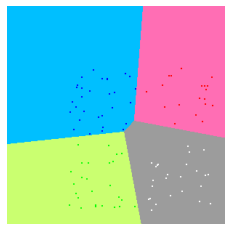


### Implementation of training procedure

With input data `x`, ground_truth `y`, and `model` as parameters, implement the gradient descent method to train your model and plot loss and accuracy vs training iterations

### Train the model

Load the data, format it, instantiate your model and start training!

In [117]:
def train(x,
          y,
          model,
          loss_function=cross_entropy_loss,
          accuracy_function=accuracy,
          max_iteration=500,
          learning_rate=0.1):
    """
    Args:
       x (2-d list): List of Values with shape: [n_samples, n_channels]
       y (1-d list): List of integers with shape: [n_samples]
       model (Module): Linear model
       loss_function (callable): Loss function to use during training
       accuracy_function (callable): Function used for calculating training accuracy
       max_iteration (int): Number of epochs to train model for
       learning_rate (numeric): Step size of the gradient update
    """
    L, A = [], [] # Initialize loss and accuracy list

    for i in range(max_iteration):
        #TODO compute y_hat and calculate the loss between y_hat and y as well as
        # the accuracy of y_hat w.r.t y.
        # FORWARD PASS
        y_hat = softmax(model(x)) # Gets predictions; converts logits to softmax
        loss = loss_function(y_hat, y)
        acc = accuracy_function(y_hat, y)

        #TODO Then You will need to calculate gradient for all parameters, and
        #do gradient descent for all the parameters.
        #The list of parameters can be easily obtained by calling
        #model.parameters() which is implemented above.
        # BACKWARD PASS
        model.zero_grad() # Reset gradients
        loss.backward() # Backpropagation

        # === Gradient Descent Update ===
        for param in model.parameters():
            param.data -= learning_rate * param.grad # Update parameters

        #Then plot the loss / accuracy vs iterations.
        if i % 20 == 19:
            print("iteration",i,"loss:",loss.data, "accuracy:",acc)
        ## record loss
        if i == 0 :
        # initialize L
            L = [loss.data] # Store the numerical value (loss.data)
            A = [acc] # Store the numerical value (acc)
        else:
            L.append(loss.data) # Store the numerical value (loss.data)
            A.append(acc) # Store the numerical value (acc)


    ## Plot Loss and Accuracy
    fig0=plt.figure(0)
    plt.plot(L,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    fig1=plt.figure(1)
    plt.plot(A,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Accuracy', fontsize=16)
    plt.show()

(100, 2) (100,) [0 1 2 3]
iteration 19 loss: 1.4263402189433187 accuracy: 0.25
iteration 39 loss: 1.1324998766597043 accuracy: 0.53
iteration 59 loss: 0.9750747748578205 accuracy: 0.69
iteration 79 loss: 0.8701830288992883 accuracy: 0.76
iteration 99 loss: 0.7926572166224441 accuracy: 0.83
iteration 119 loss: 0.7325898593084119 accuracy: 0.88
iteration 139 loss: 0.6845059553112376 accuracy: 0.91
iteration 159 loss: 0.6449845691806054 accuracy: 0.94
iteration 179 loss: 0.611785553382123 accuracy: 0.94
iteration 199 loss: 0.5833917112704493 accuracy: 0.95
iteration 219 loss: 0.5587431474955094 accuracy: 0.95
iteration 239 loss: 0.53707790162327 accuracy: 0.95
iteration 259 loss: 0.5178338396787684 accuracy: 0.96
iteration 279 loss: 0.5005866067957614 accuracy: 0.96
iteration 299 loss: 0.4850092987176157 accuracy: 0.96
iteration 319 loss: 0.47084554875827245 accuracy: 0.96
iteration 339 loss: 0.45789111845137415 accuracy: 0.96
iteration 359 loss: 0.44598101574784665 accuracy: 0.96
iterati

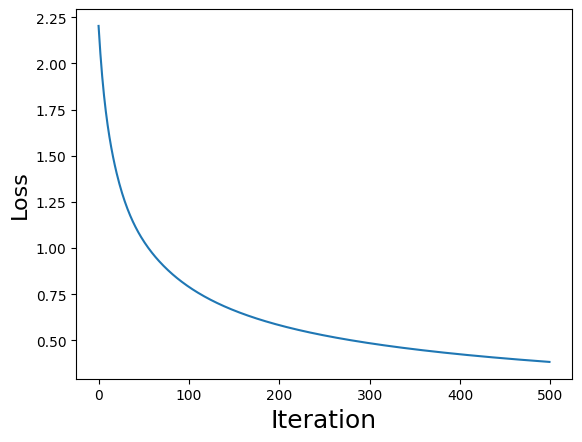

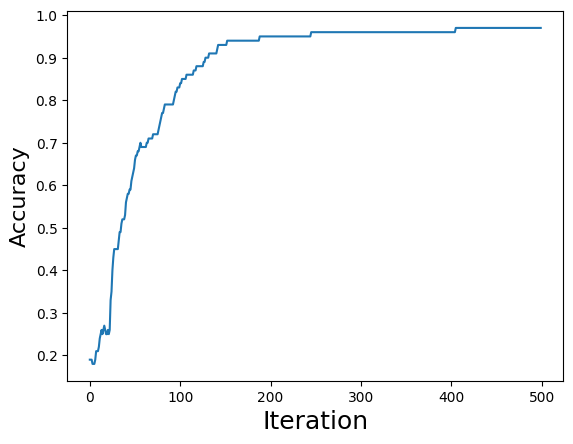

In [118]:
## Load Q3 Dataset
datapath = './Q3_data.npz'
data = np.load(datapath)

## Load Data and Parse Shape Information
X = data['X']
Y = data['Y']
print(X.shape, Y.shape, np.unique(Y))
nin = X.shape[1]
nout = np.max(Y) + 1

## Initialize data using your Value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

## Initialize a Linear Model
linear_model = LinearLayer(nin, nout)

## Train the Model using Your Data
train(x, y, linear_model)

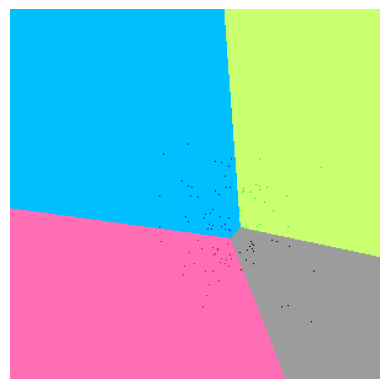

In [119]:
## Visualize learned decision boundaries
visualization(X, Y, linear_model)

## Question 4

### a) Is this dataset linear separable?
load the dataset for this question and train a linear model on this dataset and report the performance

In [145]:
## Load Q4 Dataset
datapath = './Q4_data.npz'
data = np.load(datapath)

## Parse Data and Identify Dimensions
X = data['X']
Y = data['Y']
nin = X.shape[1]
nout = int(np.max(Y)) + 1

## Initialize data using your value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

iteration 19 loss: 0.6652571936608805 accuracy: 0.8
iteration 39 loss: 0.5127964973132968 accuracy: 0.8
iteration 59 loss: 0.46042006871181507 accuracy: 0.825
iteration 79 loss: 0.4327811941475256 accuracy: 0.8
iteration 99 loss: 0.41551807431546206 accuracy: 0.8
iteration 119 loss: 0.40367392972142496 accuracy: 0.8
iteration 139 loss: 0.3950288196723266 accuracy: 0.8
iteration 159 loss: 0.3884304902417704 accuracy: 0.8
iteration 179 loss: 0.38321966734619317 accuracy: 0.8
iteration 199 loss: 0.37899174326504514 accuracy: 0.8
iteration 219 loss: 0.37548481921151394 accuracy: 0.8
iteration 239 loss: 0.3725220932642974 accuracy: 0.8
iteration 259 loss: 0.3699800641980085 accuracy: 0.8
iteration 279 loss: 0.36776997764956715 accuracy: 0.8
iteration 299 loss: 0.36582649547616536 accuracy: 0.8
iteration 319 loss: 0.36410050886552225 accuracy: 0.8
iteration 339 loss: 0.36255443105879637 accuracy: 0.8
iteration 359 loss: 0.3611590280507841 accuracy: 0.8
iteration 379 loss: 0.35989123313565885

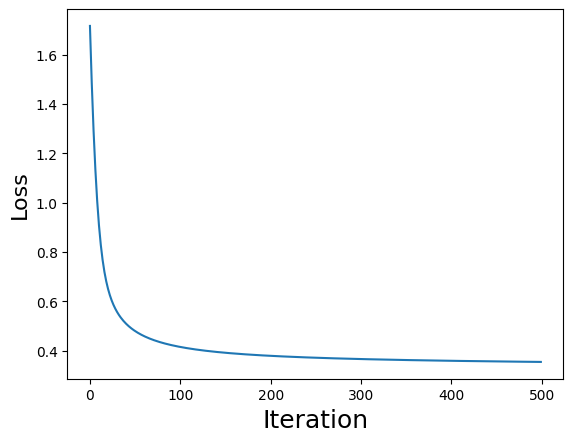

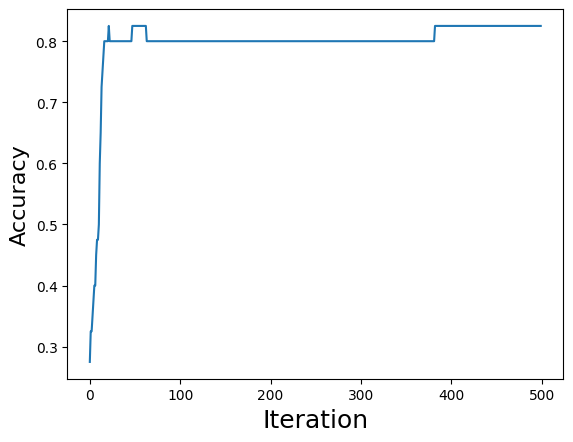

In [126]:
## Initialize Linear Model
linear_model = LinearLayer(nin, nout)

## Train Model
train(x, y, linear_model)

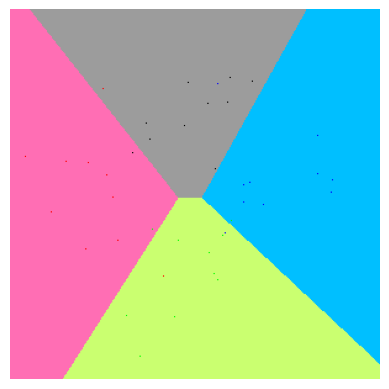

In [124]:
## Visualize Learned Decision Boundary
visualization(X, Y, linear_model)

### b) Implementation of Multi Layer Perceptron (MLP)

Implement a class `MLP` to add arbitrary layers. You will need to implement the forward function to return results `out` with `x` fed into the model.

In [148]:
class MLP(Module):

    """
    Multi Layer Perceptron
    """
    def __init__(self, dimensions):
        """
        Initialize multiple layers here in the list named self.linear_layers
        """
        assert isinstance(dimensions, list)
        assert len(dimensions) > 2
        self.linear_layers = []
        for i in range(len(dimensions) - 1):
            self.linear_layers.append(LinearLayer(dimensions[i], dimensions[i+1]))

    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]

        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """
        #TODO Implement this function and return the output of a MLP
        for i, layer in enumerate(self.linear_layers): # iterate through each lienar layer
          x = layer(x)
          if i < len(self.linear_layers) - 1: # Apply ReLU only on hidden layers
            x = [[val.relu() for val in row] for row in x]
        return softmax(x)

    def parameters(self):
        """
        Get the parameters of each layer

        Args:
            None

        Returns:
            params (list of Values): Parameters of the MLP
        """
        return [p for layer in self.linear_layers for p in layer.parameters()]

    def zero_grad(self):
        """
        Zero out the gradient of each parameter
        """
        for p in self.parameters():
            p.grad = 0

Train your MLP model and visualize the decision boundary with ground truth points.

iteration 19 loss: 1.3095607463707166 accuracy: 0.425
iteration 39 loss: 1.2896976043697097 accuracy: 0.45
iteration 59 loss: 1.2731992301690138 accuracy: 0.45
iteration 79 loss: 1.256471078704476 accuracy: 0.475
iteration 99 loss: 1.2381745691751893 accuracy: 0.5
iteration 119 loss: 1.21890606665429 accuracy: 0.55
iteration 139 loss: 1.2017352362913511 accuracy: 0.575
iteration 159 loss: 1.1888472231202114 accuracy: 0.575
iteration 179 loss: 1.179548694447582 accuracy: 0.6
iteration 199 loss: 1.1727174003601843 accuracy: 0.6
iteration 219 loss: 1.1675140077934634 accuracy: 0.6
iteration 239 loss: 1.163316917968208 accuracy: 0.6
iteration 259 loss: 1.1597286820073167 accuracy: 0.6
iteration 279 loss: 1.156463689727311 accuracy: 0.6
iteration 299 loss: 1.1533352740415987 accuracy: 0.6
iteration 319 loss: 1.1501792517418212 accuracy: 0.6
iteration 339 loss: 1.1468423497090547 accuracy: 0.6
iteration 359 loss: 1.1431709518216044 accuracy: 0.6
iteration 379 loss: 1.1390897410359722 accurac

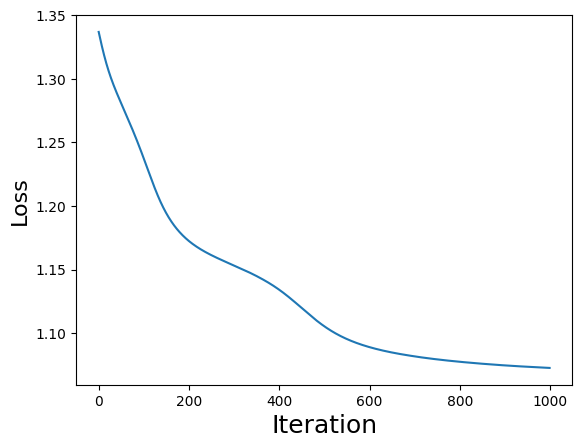

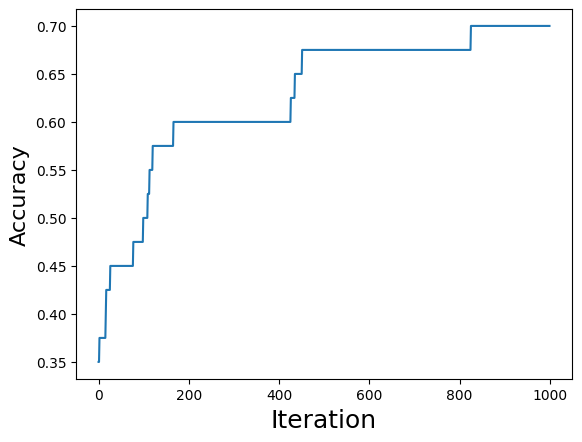

In [150]:
## Initialize MLP with Given Parameters
mlp_model = MLP([nin, 40, nout])

## Train the MLP
train(x, y, mlp_model, learning_rate = 0.01, max_iteration=1000)

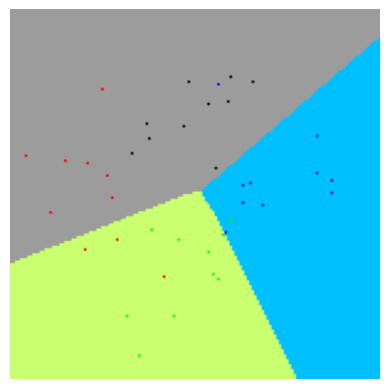

In [151]:
## Visualize Decision Boundaries
visualization(X, Y, mlp_model)

## Acknowledgement

The design of the auto grade structure are based on the work https://github.com/karpathy/micrograd